# Introduction to Deep Learning

This tutorial provides a brief introduction to deep learning. In this tutorial, simple and deep feed forward neural networks are trained. A brief discussion on the basic architecture of a simple feed forward neural network is included. Some tips on regularization and additional considerations are included, as well. The tutorial ends with an exercise.

The data for this tutorial can be cited as: 

    McGovern, A., Burke, A., Harrison, D., and G. M. Lackmann, 2020: A Machine Learning Tutorial for Operational Forecasting: Part I. Wea. Forecasting, In Press 

The framework of this notebook is based on:

    Burke, A., 2020: "Traditional Machine Learning Pipeline Applied to NWP Model Data"


# Import Modules/Data

In [ ]:
import pandas as pd
import numpy as np
import os
import random

import gdown

import matplotlib.pyplot as plt
import matplotlib

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Method 1
#! mkdir /content/AI_tutorial_data
#! cp /content/drive/MyDrive/AMS_AI_2022_SC/Data/ML_data/AI_tutorial_data/* /content/AI_tutorial_data

#Method 2
!wget -O "AI_tutorial_data.tar.gz"  "https://zenodo.org/record/5834841/files/AI_tutorial_data.tar.gz?download=1"
!mkdir AI_tutorial_data
!tar -xzvf AI_tutorial_data.tar.gz --directory /content/AI_tutorial_data
! rm *.tar.gz 

--2022-01-12 00:45:07--  https://zenodo.org/record/5834841/files/AI_tutorial_data.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268165355 (256M) [application/octet-stream]
Saving to: ‘AI_tutorial_data.tar.gz’

AI_tutorial_data.ta 100%[===================>] 255.74M  95.3MB/s    in 2.7s    

2022-01-12 00:45:11 (95.3 MB/s) - ‘AI_tutorial_data.tar.gz’ saved [268165355/268165355]

._.
./
./._keug_processed_data.csv
./keug_processed_data.csv
./._klch_processed_data.csv
./klch_processed_data.csv
./._klit_processed_data.csv
./klit_processed_data.csv
./._koma_processed_data.csv
./koma_processed_data.csv
./._kjax_processed_data.csv
./kjax_processed_data.csv
./._kcmh_processed_data.csv
./kcmh_processed_data.csv
./._kdbq_processed_data.csv
./kdbq_processed_data.csv
./._kgeg_processed_data.csv
./kgeg_processed_data.csv
./._kchs_processed_data.csv
./kc

# 1. A Brief Introduction to Deep Learning

So what is deep learning or a neural network?

<img src="https://miro.medium.com/max/663/0*R53mzDRJXZ8l6idL" width="400">


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Blausen_0657_MultipolarNeuron.png/1920px-Blausen_0657_MultipolarNeuron.png" width="400">

Deep learning is just a subset of machine learning. The basic structure of a DL model has some similarities to a biological neuron. Hence, the term "artificial neural network." The basic idea of DL is to have multiple layers that perform transformations on our original input. These transformations allow for the DL model to solve non-linear problems. Additionally, the transformations essentially create new features at each layer, which means the DL model is essentially performing feature engineering for us (this is different from other ML models, such as tree based methods, where we would typically have to provide engineered features). 


# 2. Dataset Introduction

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/NWS_Weather_Forecast_Offices.svg/720px-NWS_Weather_Forecast_Offices.svg.png" width="600">


We are going to mimic the [WxChallenge](https://www.wxchallenge.com/) (with slight changes for time constraints)
  - Predict the high/low temperature and wind speed of a given city
  - Relatively straight forward problem that is familiar to many meteorologists 
  - Learn the ML process on one city and apply your knowledge to another city or an entirely different prediction problem, it is up to you!


 **Dataset Information**
- Numerical Weather Prediction (NWP) point forecasts from the Iowa Environmental Mesonet between 1 January 2011 to 1 August 2019
- 24-hour forecast runs from the GFS, NAM, RAP, and NAM 4km at 0000, 0600, 1200, and 1800 UTC
- 70 hourly forecast variables for each model 
- NMP variables processed into 24-hour maximum, minimum, and average values for the 0600 to 0600 UTC period (same as WxChallenge)
- If one NWP forecast is missing, replaced with average value from all other NWP forecasts for the given variable
- Observations are NWS ASOS point data for a given city  
- Days with missing observations were removed

# 3. Loading Data and X-/Y- Variable Selection

As with regular machine learning, it is important that we preprocess our data. Below, we follow the same steps that we have before. 

One item you will note below is that we are not going to use any features that contain information directly related to temperature (i.e., our X data). You might think why would you do that?? And, you would be right! If you had a variable like model (e.g., GFS, NAM) forecasted temperature and you were predicting temperature, you should absolutely include it as a feature. But, lets make this problem a bit more challenging, by not including temperature variables.

In [ ]:
total_dataset = pd.read_csv('AI_tutorial_data/kdfw_processed_data.csv',index_col=0).sort_values(by='date')
total_dataset = total_dataset.replace('********', np.nan).replace(np.inf,np.nan).dropna(how='any',axis=1)
total_dataset['date'] = pd.to_datetime(total_dataset['date'])
total_dataset

,date,OBS_tmpf_max,OBS_tmpf_min,OBS_sknt_max,OBS_phour,GFS0_pmsl_max,GFS0_pmsl_min,GFS0_pmsl_avg,GFS0_pres_max,GFS0_pres_min,GFS0_pres_avg,GFS0_sktc_max,GFS0_sktc_min,GFS0_sktc_avg,GFS0_stc1_max,GFS0_stc1_min,GFS0_stc1_avg,GFS0_snfl_max,GFS0_snfl_min,GFS0_snfl_avg,GFS0_wtns_max,GFS0_wtns_min,GFS0_wtns_avg,GFS0_p01m_max,GFS0_p01m_min,GFS0_p01m_avg,GFS0_c01m_max,GFS0_c01m_min,GFS0_c01m_avg,GFS0_stc2_max,GFS0_stc2_min,GFS0_stc2_avg,GFS0_lcld_max,GFS0_lcld_min,GFS0_lcld_avg,GFS0_mcld_max,GFS0_mcld_min,GFS0_mcld_avg,GFS0_hcld_max,GFS0_hcld_min,...,NAMMOS0_vis_max,NAMMOS0_vis_min,NAMMOS0_vis_avg,NAMMOS0_poz_max,NAMMOS0_poz_min,NAMMOS0_poz_avg,NAMMOS0_pos_max,NAMMOS0_pos_min,NAMMOS0_pos_avg,NAMMOS12_n_x_max,NAMMOS12_tmp_max,NAMMOS12_tmp_min,NAMMOS12_tmp_avg,NAMMOS12_dpt_max,NAMMOS12_dpt_min,NAMMOS12_dpt_avg,NAMMOS12_wdr,NAMMOS12_wsp_max,NAMMOS12_wsp_min,NAMMOS12_wsp_avg,NAMMOS12_p06_max,NAMMOS12_p06_min,NAMMOS12_p06_avg,NAMMOS12_p12_max,NAMMOS12_q06_max,NAMMOS12_q06_min,NAMMOS12_q06_avg,NAMMOS12_q12_max,NAMMOS12_cig_max,NAMMOS12_cig_min,NAMMOS12_cig_avg,NAMMOS12_vis_max,NAMMOS12_vis_min,NAMMOS12_vis_avg,NAMMOS12_poz_max,NAMMOS12_poz_min,NAMMOS12_poz_avg,NAMMOS12_pos_max,NAMMOS12_pos_min,NAMMOS12_pos_avg
0,2011-01-01,14.00,3.02,22.0,0.0000,1025.800000,1020.300000,1022.960000,807.300000,800.800000,804.650000,-8.700000,-15.50,-13.420000,266.100000,264.100000,264.930000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15.000000,0.0,1.500000,85.000000,0.0,54.300000,80.000000,0.000000,...,7.0,7.0,7.0,0.666667,0.000000,0.097222,100.000000,97.333333,99.486111,20.0,16.0,13.0,14.000000,-4.0,-6.0,-5.000000,270.0,25.0,18.0,20.750000,1.0,1.0,1.0,6.5,0.0,0.0,0.0,0.0,8.0,8.0,8.0,7.0,7.0,7.0,0.666667,0.000000,0.097222,100.000000,97.333333,99.486111
1,2011-01-02,28.94,15.98,31.0,0.0000,1025.700000,1014.000000,1020.850000,807.600000,805.400000,806.511111,-1.800000,-14.90,-9.461111,267.800000,264.200000,265.561111,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,100.000000,0.0,11.722222,65.000000,0.000000,...,7.0,7.0,7.0,1.000000,0.000000,0.394048,100.000000,97.000000,99.040774,13.0,28.0,18.0,22.571429,8.0,-6.0,0.571429,260.0,23.0,14.0,18.857143,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,8.0,8.0,8.0,7.0,7.0,7.0,1.000000,0.000000,0.394048,100.000000,97.000000,99.040774
2,2011-01-03,28.04,10.94,23.0,0.0000,1024.100000,1013.300000,1019.970833,809.900000,804.800000,807.183333,-1.400000,-11.30,-7.800000,268.300000,266.200000,267.016667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.083333,78.000000,0.0,8.043478,85.000000,0.000000,...,7.0,7.0,7.0,0.750000,0.500000,0.625000,98.000000,97.250000,97.625000,0.0,21.0,21.0,21.000000,11.0,11.0,11.000000,330.0,10.0,10.0,10.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,8.0,7.0,7.0,7.0,0.750000,0.500000,0.625000,98.000000,97.250000,97.625000
3,2011-01-04,35.60,10.04,22.0,0.0000,1024.900000,1009.900000,1019.200000,809.500000,803.800000,806.837500,0.000000,-11.70,-7.566667,268.200000,265.600000,266.954167,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.041667,54.000000,0.0,3.958333,0.000000,0.000000,...,7.0,7.0,7.0,0.666667,0.666667,0.666667,97.333333,97.333333,97.333333,0.0,31.0,31.0,31.000000,11.0,11.0,11.000000,270.0,14.0,14.0,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,8.0,7.0,7.0,7.0,0.666667,0.666667,0.666667,97.333333,97.333333,97.333333
4,2011-01-05,35.96,24.08,30.0,0.0000,1023.200000,1014.600000,1019.041667,811.400000,805.300000,807.925000,-0.100000,-8.20,-5.300000,269.300000,267.400000,268.129167,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,68.000000,0.0,8.375000,90.000000,0.000000,...,7.0,7.0,7.0,0.750000,0.750000,0.750000,95.750000,95.750000,95.750000,0.0,32.0,32.0,32.000000,15.0,15.0,15.000000,290.0,27.0,27.0,27.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8

In [ ]:
#Subset X data. Choose desired columns to subset. Make sure to keep the date so we can split the dataset.
desired_columns = ['date', 'lcld', 'mcld', 'hcld', 'pres', 'wsp', 'p06', 'rh']
total_feature_data = total_dataset.loc[:, total_dataset.columns.str.contains('|'.join(desired_columns))]
total_feature_data

,date,GFS0_pres_max,GFS0_pres_min,GFS0_pres_avg,GFS0_lcld_max,GFS0_lcld_min,GFS0_lcld_avg,GFS0_mcld_max,GFS0_mcld_min,GFS0_mcld_avg,GFS0_hcld_max,GFS0_hcld_min,GFS0_hcld_avg,GFS0_wspd_max,GFS0_wspd_min,GFS0_wspd_avg,GFS0_rh_max,GFS0_rh_min,GFS0_rh_avg,GFS6_pres_max,GFS6_pres_min,GFS6_pres_avg,GFS6_lcld_max,GFS6_lcld_min,GFS6_lcld_avg,GFS6_mcld_max,GFS6_mcld_min,GFS6_mcld_avg,GFS6_hcld_max,GFS6_hcld_min,GFS6_hcld_avg,GFS6_wspd_max,GFS6_wspd_min,GFS6_wspd_avg,GFS6_rh_max,GFS6_rh_min,GFS6_rh_avg,GFS12_pres_max,GFS12_pres_min,GFS12_pres_avg,...,NAM4km18_wspd_avg,NAM4km18_rh_max,NAM4km18_rh_min,NAM4km18_rh_avg,GFSMOS0_wsp_max,GFSMOS0_wsp_min,GFSMOS0_wsp_avg,GFSMOS0_p06_max,GFSMOS0_p06_min,GFSMOS0_p06_avg,GFSMOS6_wsp_max,GFSMOS6_wsp_min,GFSMOS6_wsp_avg,GFSMOS6_p06_max,GFSMOS6_p06_min,GFSMOS6_p06_avg,GFSMOS12_wsp_max,GFSMOS12_wsp_min,GFSMOS12_wsp_avg,GFSMOS12_p06_max,GFSMOS12_p06_min,GFSMOS12_p06_avg,GFSMOS18_wsp_max,GFSMOS18_wsp_min,GFSMOS18_wsp_avg,GFSMOS18_p06_max,GFSMOS18_p06_min,GFSMOS18_p06_avg,NAMMOS0_wsp_max,NAMMOS0_wsp_min,NAMMOS0_wsp_avg,NAMMOS0_p06_max,NAMMOS0_p06_min,NAMMOS0_p06_avg,NAMMOS12_wsp_max,NAMMOS12_wsp_min,NAMMOS12_wsp_avg,NAMMOS12_p06_max,NAMMOS12_p06_min,NAMMOS12_p06_avg
0,2011-01-01,807.300000,800.800000,804.650000,15.000000,0.0,1.500000,85.000000,0.0,54.300000,80.000000,0.000000,26.600000,22.200000,12.000000,18.470000,73.200000,59.900000,68.060000,807.700000,800.200000,804.475000,0.000000,0.0,0.000000,91.000000,0.0,64.000000,66.000000,0.000000,35.375000,23.700000,13.100000,19.125000,73.100000,59.300000,66.387500,806.9,802.3,805.116667,...,21.242257,69.1375,59.5250,64.492743,18.0,11.0,14.625000,10.0,3.0,5.666667,18.0,11.0,15.5,5.0,1.0,3.0,20.0,12.0,16.250000,5.0,5.0,5.0,20.25,13.0,16.78125,5.25,2.5,3.666667,20.25,13.0,16.78125,5.25,2.5,3.666667,25.0,18.0,20.750000,1.0,1.0,1.0
1,2011-01-02,807.600000,805.400000,806.511111,0.000000,0.0,0.000000,100.000000,0.0,11.722222,65.000000,0.000000,23.500000,22.200000,13.000000,18.577778,78.400000,54.900000,68.294444,808.000000,805.300000,806.812500,0.000000,0.0,0.000000,96.000000,0.0,13.312500,73.000000,0.000000,29.625000,22.100000,13.500000,18.843750,79.000000,55.300000,67.487500,807.9,804.6,806.700000,...,21.307006,78.7875,55.7375,67.266939,16.0,13.0,14.333333,0.0,0.0,0.000000,16.0,14.0,15.0,2.0,0.0,1.0,18.0,12.0,15.571429,0.0,0.0,0.0,18.00,12.0,15.50000,0.00,0.0,0.000000,22.00,17.0,19.00000,1.00,1.0,1.000000,23.0,14.0,18.857143,1.0,1.0,1.0
2,2011-01-03,809.900000,804.800000,807.183333,1.000000,0.0,0.083333,78.000000,0.0,8.043478,85.000000,0.000000,8.695652,18.900000,5.200000,12.133333,88.200000,48.900000,75.962500,809.500000,805.100000,807.695833,0.000000,0.0,0.000000,74.000000,0.0,10.869565,36.000000,0.000000,5.260870,16.400000,6.300000,12.758333,85.700000,46.600000,73.675000,809.7,805.0,807.681818,...,11.791259,91.0875,62.1625,78.751146,11.0,11.0,11.000000,1.0,1.0,1.000000,11.0,11.0,11.0,1.0,1.0,1.0,11.0,11.0,11.000000,1.0,1.0,1.0,10.00,8.0,9.00000,1.00,1.0,1.000000,10.00,10.0,10.00000,1.00,1.0,1.000000,10.0,10.0,10.000000,1.0,1.0,1.0
3,2011-01-04,809.500000,803.800000,806.837500,1.000000,0.0,0.041667,54.000000,0.0,3.958333,0.000000,0.000000,0.000000,21.800000,8.100000,12.200000,84.700000,67.500000,76.733333,809.400000,804.200000,806.708333,1.000000,0.0,0.041667,29.000000,0.0,2.000000,6.000000,0.000000,0.250000,18.000000,8.100000,11.304167,84.600000,67.500000,77.245833,809.6,805.0,806.987500,...,14.262500,83.9875,65.0250,74.791667,7.0,7.0,7.000000,0.0,0.0,0.000000,9.0,9.0,9.0,0.0,0.0,0.0,13.0,13.0,13.000000,0.0,0.0,0.0,10.20,10.2,10.20000,0.00,0.0,0.000000,8.00,8.0,8.00000,0.00,0.0,0.000000,14.0,14.0,14.000000,0.0,0.0,0.0
4,2011-01-05,811.400000,805.300000,807.925000,0.000000,0.0,0.000000,68.000000,0.0,8.375000,90.000000,0.000000,34.208333,26.800000,18.000000,22.775000,79.000000,58.500000,72.050000,812.100000,804.900000,807.395833,0.000000,0.0,0.000000,71.000000,0.0,6.750000,77.000000,0.000000,30.250000,26.700000,18.900000,23.241667,77.900000,61.700000,72.116667,811

In [ ]:
#Subset Y data.
total_label_data = total_dataset.filter(like='OBS')
total_label_data

,OBS_tmpf_max,OBS_tmpf_min,OBS_sknt_max,OBS_phour
0,14.00,3.02,22.0,0.0000
1,28.94,15.98,31.0,0.0000
2,28.04,10.94,23.0,0.0000
3,35.60,10.04,22.0,0.0000
4,35.96,24.08,30.0,0.0000
...,...,...,...,...
3134,88.00,57.90,13.0,0.0000
3135,93.00,54.00,16.0,0.0000
3136,84.00,63.00,18.0,0.0003
3137,81.00,57.90,11.0,0.0002


Choose our y-variable (i.e., the variable we want to predict) and split the dataset into a train/test set based on date. For this activity, we are going to focus on predicting the observed maximum temperature for a given day.

In [ ]:
predict_variable = 'OBS_tmpf_max'
split_date = datetime(2017, 1, 1)

#Also going to remove data points where the observations were bad
good_obs_rows = (total_label_data['OBS_tmpf_max'] != 0)

#Training data between 2011 and 2016
train_rows = (total_feature_data['date'] < (split_date - timedelta(days=15))) & (good_obs_rows)
train_features = total_feature_data.loc[train_rows, :]
train_features = train_features.drop('date', axis='columns')
train_labels = total_label_data.loc[train_rows, predict_variable]

#Test data 2017 and beyond
test_rows = (total_feature_data['date'] > (split_date + timedelta(days=15))) & (good_obs_rows)
test_features = total_feature_data.loc[test_rows, :]
test_features = test_features.drop('date', axis='columns')
test_labels = total_label_data.loc[test_rows, predict_variable]

# 4. Scaling Data

As we have seen in other lessons, scaling data can be really important. It is extremely important in deep learning! The primary reason for scaling is to speed up convergance. 

<img src="https://miro.medium.com/max/700/1*vXpodxSx-nslMSpOELhovg.png" width="600">

[Image from Imad Dabbura TDS Article](https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3)

Below we will use the sci-kit learn StandardScaler (i.e., it will make all of the features have a mean of 0 and a standard deviation of 1). But, other scalers can certainly be tested such as MinMax or Robust scalers.

Also! Note, we are scaling our Y variable as well. 

In [ ]:
from sklearn.preprocessing import StandardScaler

standard_model_X = StandardScaler().fit(train_features)
standard_train_features = standard_model_X.transform(train_features)
standard_test_features = standard_model_X.transform(test_features)

standard_model_Y = StandardScaler().fit(train_labels.values.reshape(-1, 1))
standard_train_labels = standard_model_Y.transform(train_labels.values.reshape(-1, 1))
standard_test_labels = standard_model_Y.transform(test_labels.values.reshape(-1, 1))

In [ ]:
pd.DataFrame(standard_train_features, columns = train_features.columns)

,GFS0_pres_max,GFS0_pres_min,GFS0_pres_avg,GFS0_lcld_max,GFS0_lcld_min,GFS0_lcld_avg,GFS0_mcld_max,GFS0_mcld_min,GFS0_mcld_avg,GFS0_hcld_max,GFS0_hcld_min,GFS0_hcld_avg,GFS0_wspd_max,GFS0_wspd_min,GFS0_wspd_avg,GFS0_rh_max,GFS0_rh_min,GFS0_rh_avg,GFS6_pres_max,GFS6_pres_min,GFS6_pres_avg,GFS6_lcld_max,GFS6_lcld_min,GFS6_lcld_avg,GFS6_mcld_max,GFS6_mcld_min,GFS6_mcld_avg,GFS6_hcld_max,GFS6_hcld_min,GFS6_hcld_avg,GFS6_wspd_max,GFS6_wspd_min,GFS6_wspd_avg,GFS6_rh_max,GFS6_rh_min,GFS6_rh_avg,GFS12_pres_max,GFS12_pres_min,GFS12_pres_avg,GFS12_lcld_max,...,NAM4km18_wspd_avg,NAM4km18_rh_max,NAM4km18_rh_min,NAM4km18_rh_avg,GFSMOS0_wsp_max,GFSMOS0_wsp_min,GFSMOS0_wsp_avg,GFSMOS0_p06_max,GFSMOS0_p06_min,GFSMOS0_p06_avg,GFSMOS6_wsp_max,GFSMOS6_wsp_min,GFSMOS6_wsp_avg,GFSMOS6_p06_max,GFSMOS6_p06_min,GFSMOS6_p06_avg,GFSMOS12_wsp_max,GFSMOS12_wsp_min,GFSMOS12_wsp_avg,GFSMOS12_p06_max,GFSMOS12_p06_min,GFSMOS12_p06_avg,GFSMOS18_wsp_max,GFSMOS18_wsp_min,GFSMOS18_wsp_avg,GFSMOS18_p06_max,GFSMOS18_p06_min,GFSMOS18_p06_avg,NAMMOS0_wsp_max,NAMMOS0_wsp_min,NAMMOS0_wsp_avg,NAMMOS0_p06_max,NAMMOS0_p06_min,NAMMOS0_p06_avg,NAMMOS12_wsp_max,NAMMOS12_wsp_min,NAMMOS12_wsp_avg,NAMMOS12_p06_max,NAMMOS12_p06_min,NAMMOS12_p06_avg
0,-1.414192,-1.333548,-1.272532,-0.313843,-0.116097,-0.372082,0.322771,-0.151676,1.338133,-0.007505,-0.295694,-0.318479,0.193735,1.585506,1.052583,0.035110,1.735021,1.021555,-1.345899,-1.467831,-1.314760,-0.688294,-0.118383,-0.457873,0.473770,-0.152428,1.731436,-0.410570,-0.291052,0.021187,0.420990,1.874471,1.194286,0.011936,1.687482,0.919199,-1.505532,-1.072876,-1.172127,-0.688756,...,2.258946,-0.060273,-0.021442,-0.034352,1.826893,0.310658,1.096474,46.405424,44.242966,45.927135,1.652819,0.222751,1.142540,42.572815,32.969683,42.184073,1.006117,-0.239424,0.422396,45.731077,45.731077,45.731077,1.466081,0.106280,0.815809,45.813081,43.300172,44.993199,2.384524,0.801285,1.628552,45.031869,40.590852,43.512472,2.299421,1.002906,1.512898,26.913441,26.913441,26.913441
1,-1.349366,-0.525448,-0.906486,-0.696776,-0.116097,-0.456899,0.732177,-0.151676,-0.527945,-0.484092,-0.295694,-0.434962,0.193735,1.826533,1.073641,0.341015,1.440207,1.035283,-1.281377,-0.562904,-0.854965,-0.688294,-0.118383,-0.457873,0.611494,-0.152428,-0.469463,-0.192933,-0.291052,-0.193390,0.189369,1.971398,1.138981,0.359025,1.451528,0.983764,-1.289131,-0.667934,-0.861666,-0.688756,...,2.274261,-0.060273,-0.021442,-0.034352,1.393304,0.744710,1.033198,-0.023470,-0.027126,-0.024844,1.243935,0.836576,1.040275,17.010330,-0.030331,14.039801,0.694500,-0.239424,0.316639,-0.025233,-0.025233,-0.025233,1.043645,-0.081588,0.575142,-0.025078,-0.027877,-0.026332,2.767423,1.678483,2.114712,8.554349,16.216178,11.844546,1.928075,0.258854,1.161010,26.913441,26.913441,26.913441
2,-0.852364,-0.630852,-0.774272,-0.671247,-0.116097,-0.452187,0.131715,-0.151676,-0.689175,0.151357,-0.295694,-0.991240,-0.285467,-0.053478,-0.185486,0.917527,1.086430,1.484304,-0.958767,-0.598392,-0.681210,-0.688294,-0.118383,-0.457873,0.005506,-0.152428,-0.575537,-1.343302,-0.291052,-1.102608,-0.635779,0.226725,-0.057671,0.753177,0.938328,1.346941,-0.899608,-0.597510,-0.669151,-0.688756,...,0.023523,-0.060273,-0.021442,-0.034352,0.309331,0.310658,0.310048,4.619419,14.729571,8.084329,0.221725,0.222751,0.222150,8.489502,32.969683,14.039801,-0.396159,-0.395282,-0.395827,9.126029,9.126029,9.126029,-0.458351,-0.833059,-0.645802,8.706000,17.303343,12.251722,0.141828,0.143386,0.142683,8.554349,16.216178,11.844546,-0.485677,-0.485198,-0.485562,26.913441,26.913441,26.913441
3,-0.938799,-0.806526,-0.842291,-0.671247,-0.116097,-0.454543,-0.523334,-0.151676,-0.868217,-2.549304,-0.295694,-1.317982,0.135650,0.645501,-0.172460,0.711629,2.183138,1.529442,-0.980274,-0.758085,-0.875455,-0.662686,-0.118383,-0.455572,-1.234014,-0.152428,-0.960662,-2.276034,-0.291052,-1.289603,-0.404159,0.662893,-0.343622,0.688465,2.171187,1.556533,-0.921248,-0.597510,-0.805293,-0.688756,...,0.608040,-0.060273,-0.021442,-0.034352,-0.557848,-0.557445,-0.5

# 5. The Framework of Our First Deep Learning Model

Alright, we have our data sorted out. Now lets dive into creating our first deep learning model. We are going to make use of TensorFlow/Keras. Whats the difference? TensorFlow contains most of the "tools" to train the model. But, using pure TensorFlow is kind of hard, so Keras was designed to "sit" on top of TensorFlow and create an API that is easier for someone to interact with. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential  #Functional
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

In [ ]:
input_dim = standard_train_features.shape[1] #The input dimension is simply the number of columns (features) in our dataset

model = Sequential()  #Input Layer
model.add(Dense(32, input_dim=input_dim, activation='relu'))  #Hidden Layer 1
model.add(Dense(1))  #Output Layer

model.compile(loss='mean_squared_error') 

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 32)                8096      
                                                                 
 dense_73 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


What does this summary mean? 

<img src="http://uc-r.github.io/public/images/analytics/deep_learning/fig18_1.png" width="300">

[Image Source](http://uc-r.github.io/feedforward_DNN)

The above image is not the architecture of our exact model, but it is very similar. If we were to draw our model, there would be 252 green dots. Each of those green dots would represent a feature that we are inputing into our model. How did I come up with 252? Thats how many columns are in our train_features dataframe (i.e., each of the columns is a feature).


In [ ]:
train_features.shape

(2176, 252)

What about the blue circles? Each of the blue circles represents a node. If we were to be drawing our model, we would have 32 blue circles (this corresponds to the line containing Dense(32, ...)). Finally, the 32 nodes will be reduced to 1 node (red circle) that will be used to formulate our final prediction.

Okay, that explains the the nodes. What about the connections between each of the nodes? And, what is going on inside a node?

The figure below shows what is going on between the input and hidden layers. 
1. Each feature (which has been scaled) is multiplied by a weight. 
2. Those products are summed in each of the nodes.
3. The sum is passed through an activation function.

This presentation isn't about the theory of deep learning, but if you take anything about the theory away, a great phrase to remember is "Weight, Sum, Activation" 

<img src="https://drive.google.com/uc?export=view&id=1R8zWxNWayojFrfJvY00FYuT9_43u7txU" width="600">

A few examples of activation functions. Note, we are using a ReLU activation in our hidden layers.

<img src="https://hsf-training.github.io/hsf-training-ml-webpage/plots/act_functions.png" width="600">

So, the output that comes out of one node in the hidden layer, is essentially a new feature. So, the final step is to take the new features and use them to produce a final prediction. This step occurs between the hidden layer and the output layer. The steps between the input and hidden layer are repeated. "Weight, Sum, Activation"

<img src="https://drive.google.com/uc?export=view&id=1_yhy79G0BJzbqGMGZ57_c1fs6nrhKxKg" width="600">

Remember, if we were to draw out our entire model it would have 252 green circles and 32 blue circles. But, the item to take away from the above figure is that each of the small grey cirlces is a parameter that our model is going to tune during the training process.



In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 32)                8096      
                                                                 
 dense_73 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


The above summary shows the "pathway" that data will take through your neural network. This model is very simple.

1. The 252 training features we selected will be directed to 32 nodes.
2. Each feature will be multiplied by a unique weight at each node. (252*32)
3. The products will be summed together and have a biased applied (32).
(The above steps 252*32 + 32 = 8096)
4. The sum of the products will be passed through an activation function. This step will essentially produce 32 new "features"

(Process restarts)

5. These 32 new features will be directed to 1 node. 
6. Each feature will be multiplied by a unique weight at the node. (32*1)
7. The products will be summed together and a bias applied. (1) (Note, these could be passed through another activation function, but for now we will just let them output linearly).

So, for the number of trainable params:

252 * 32 + 32 + 32*1 + 1 = 8,129 parameters

# 6. Training Our First Deep Learning Model

Alright enough theory. Lets get to the fun part and actually train the model. The call to fit in keras, is a lot like the call to fit in scikit-learn. The two parameters you must include are your X and Y data. The other two parameters you'll notice below are epochs and batch_size. Epochs just indicates the number of times we will pass through all of our training data. The batch_size says how many examples we will use to update the weights/biases of our model as we go through each pass (i.e., epoch). 

In [ ]:
history = model.fit(standard_train_features, 
                    standard_train_labels, 
                    epochs=250, 
                    batch_size=64, 
                    validation_data=(standard_test_features, standard_test_labels))

Epoch 1/250
34/34 [==============================] - 0s 5ms/step - loss: 0.9729 - val_loss: 0.4774
Epoch 2/250
34/34 [==============================] - 0s 3ms/step - loss: 0.4650 - val_loss: 0.4750
Epoch 3/250
34/34 [==============================] - 0s 3ms/step - loss: 0.2996 - val_loss: 0.4404
Epoch 4/250
34/34 [==============================] - 0s 3ms/step - loss: 0.2436 - val_loss: 0.3956
Epoch 5/250
34/34 [==============================] - 0s 3ms/step - loss: 0.2266 - val_loss: 0.3851
Epoch 6/250
34/34 [==============================] - 0s 3ms/step - loss: 0.2223 - val_loss: 0.3584
Epoch 7/250
34/34 [==============================] - 0s 3ms/step - loss: 0.1988 - val_loss: 0.3869
Epoch 8/250
34/34 [==============================] - 0s 3ms/step - loss: 0.1991 - val_loss: 0.3329
Epoch 9/250
34/34 [==============================] - 0s 3ms/step - loss: 0.1806 - val_loss: 0.3815
Epoch 10/250
34/34 [==============================] - 0s 3ms/step - loss: 0.1832 - val_loss: 0.3251
Epoch 11/

Alright, our first model is trained. Lets see how we did!

First, lets look at our predictions. Remember, we need to inverse the transform of the predicted data to get back into non-standardized temperature.

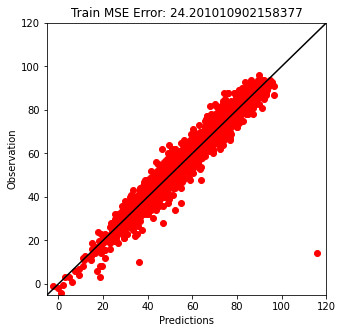

In [ ]:
from sklearn.metrics import mean_squared_error

def makePlot(predictions, labels, title):
  plt.figure(figsize=(5, 5))
  plt.plot(predictions, labels, 'ro')
  plt.plot(range(-10, 130), range(-10, 130), 'k')
  plt.xlim(-5, 120)
  plt.ylim(-5, 120)
  plt.title(title)
  plt.xlabel('Predictions')
  plt.ylabel('Observation')
  plt.show()

def make3Plots(model, standard_train_features, standard_test_features, history, standard_model_Y):
  plt.figure(figsize=(15, 5))
  #First lets get predictions from the training set
  plt.subplot(1,3,1)
  predictions = model.predict(standard_train_features)
  predictions = standard_model_Y.inverse_transform(predictions)
  trainMSE = mean_squared_error(predictions, train_labels)

  title = "Train MSE Error: " + str(trainMSE)
  plt.plot(predictions, train_labels, 'ro')
  plt.plot(range(-10, 130), range(-10, 130), 'k')
  plt.xlim(-5, 120)
  plt.ylim(-5, 120)
  plt.title(title)
  plt.xlabel('Predictions')
  plt.ylabel('Observation')
  
  #Now get predictions for the test set
  plt.subplot(1,3,2)
  predictions = model.predict(standard_test_features)
  predictions = standard_model_Y.inverse_transform(predictions)
  testMSE = mean_squared_error(predictions, test_labels)

  title = "Test MSE Error: " + str(testMSE)
  plt.plot(predictions, test_labels, 'ro')
  plt.plot(range(-10, 130), range(-10, 130), 'k')
  plt.xlim(-5, 120)
  plt.ylim(-5, 120)
  plt.title(title)
  plt.xlabel('Predictions')
  plt.ylabel('Observation')

  #Loss for train/test set
  plt.subplot(1,3,3)
  plt.plot(history.history['loss'], 'r', label='Train')
  plt.plot(history.history['val_loss'], 'b', label='Test')
  plt.ylim([0, 1])
  plt.legend()
  
  plt.show()

#First lets get predictions from the training set
predictions = model.predict(standard_train_features)
predictions = standard_model_Y.inverse_transform(predictions)
trainMSE = mean_squared_error(predictions, train_labels)

title = "Train MSE Error: " + str(trainMSE)
makePlot(predictions, train_labels, title)

Decent performance. What about our performance on the test set?

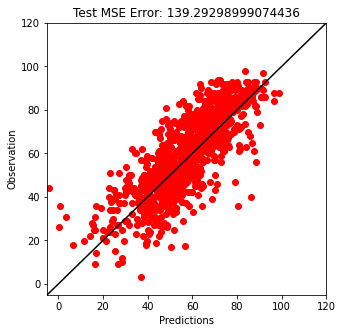

In [ ]:
#Now get predictions for the test set
predictions = model.predict(standard_test_features)
predictions = standard_model_Y.inverse_transform(predictions)
testMSE = mean_squared_error(predictions, test_labels)

title = "Test MSE Error: " + str(testMSE)
makePlot(predictions, test_labels, title)

Yikes... clearly there is a large increase in the error between the training and testing sets. We are overfitting badly. Lets take a looks at the loss history of our model.

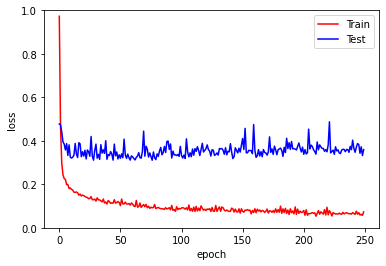

In [ ]:
plt.plot(history.history['loss'], 'r', label='Train')
plt.plot(history.history['val_loss'], 'b', label='Test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend()
plt.show()

Alright, so we are clearly overfitting to our training set. We definitely need to fix this. But first, lets train a slightly deeper model (2 hidden layers) so that we can see that our **training** set skill does improve when we increase the model complexity.


In [ ]:
input_dim = standard_train_features.shape[1] #The input dimension is simply the number of columns (features) in our dataset

model = Sequential()  #Input Layer
model.add(Dense(32, input_dim=input_dim, activation='relu'))  #Hidden Layer 1
model.add(Dense(32, activation='relu'))  #Hidden Layer 2
model.add(Dense(1))  #Output Layer

model.compile(loss='mean_squared_error')

print(model.summary())

history2 = model.fit(standard_train_features, 
                     standard_train_labels, 
                     epochs=250, 
                     batch_size=64, 
                     verbose=0, 
                     validation_data=(standard_test_features, standard_test_labels))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 32)                8096      
                                                                 
 dense_75 (Dense)            (None, 32)                1056      
                                                                 
 dense_76 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,185
Trainable params: 9,185
Non-trainable params: 0
_________________________________________________________________
None


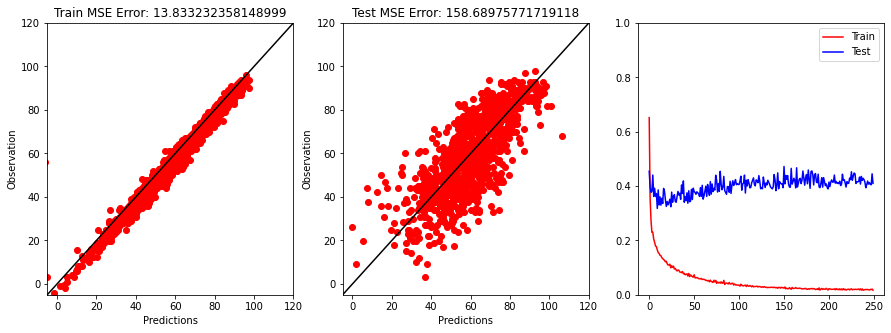

In [ ]:
make3Plots(model, standard_train_features, standard_test_features, history2, standard_model_Y)

# 7. Regularization

So, we can see that the fit of our model gets better as we increase the complexity of the neural network. However, we also see that it increases the risk of overfitting which ultimately leads to poorer performance on our testing set. So, we need to implement some measures to prevent overfitting. With that in mind, lets investigate a few regularization methods.

**Regularization of Weights**

The first method we will look at is simply regularizing the weights of the model. This concept is similar to that which might used with a logistic regression model. We want to reduce the propensity for a couple of the weights from becoming so large that they dominate all of the decision making (as this leads to overfitting). So, lets go back to our model that we previously had problems fitting.

In [ ]:
regularizer = tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)

input_dim = standard_train_features.shape[1] #The input dimension is simply the number of columns (features) in our dataset

model = Sequential()  #Input Layer
model.add(Dense(32, input_dim=input_dim, kernel_regularizer=regularizer, activation='relu'))  #Hidden Layer 1
model.add(Dense(32, kernel_regularizer=regularizer, activation='relu'))  #Hidden Layer 2
model.add(Dense(1))  #Output Layer

model.compile(loss='mean_squared_error') 

print(model.summary())

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history3 = model.fit(standard_train_features[730:, :], 
                     standard_train_labels[730:, :], 
                     epochs=250, 
                     callbacks=callback, 
                     batch_size=64, 
                     verbose=0, 
                     validation_data=(standard_train_features[:730, :], standard_train_labels[:730, :]))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 32)                8096      
                                                                 
 dense_78 (Dense)            (None, 32)                1056      
                                                                 
 dense_79 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,185
Trainable params: 9,185
Non-trainable params: 0
_________________________________________________________________
None


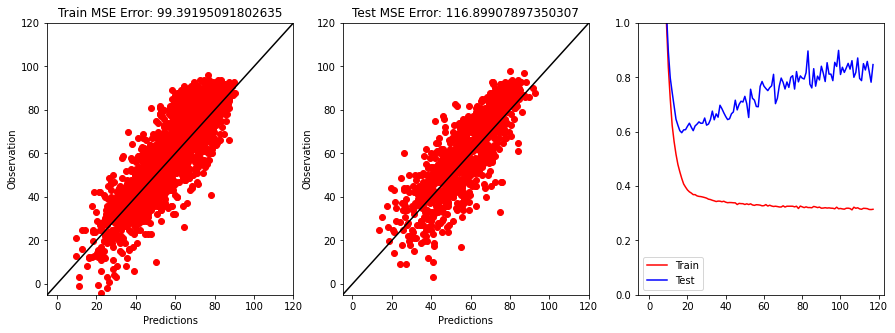

In [ ]:
make3Plots(model, standard_train_features, standard_test_features, history3, standard_model_Y)

**Dropout**

Another regularization method that is commonly used is Dropout. A great analogy for Dropout that I had explained to me once, is to imagine that every morning before you went into work, your boss randomly chose 50% of your coworkers to take the day off. At first, this situation would create a mess. But, overtime, after some additional training, everyone would learn how to perform the tasks that the 50% who didn't show up typically performed. Then, hopefully, when all 100% of the employees come back into work, the workplace would become more efficient.

<img src="https://miro.medium.com/max/1400/1*iWQzxhVlvadk6VAJjsgXgg.png" width="450">

[Original image from Srivastava et al. 2014](https://jmlr.org/papers/v15/srivastava14a.html)

Below we apply 50% dropout. Note, the location of the dropout layers. They are added after the dense layers (but, not after the final dense layer).

In [ ]:
input_dim = standard_train_features.shape[1] #The input dimension is simply the number of columns (features) in our dataset

model = Sequential()  #Input Layer
model.add(Dense(32, input_dim=input_dim, activation='relu'))  #Hidden Layer 1
model.add(Dropout(.20))
model.add(Dense(32, activation='relu'))  #Hidden Layer 2
model.add(Dropout(.20))
model.add(Dense(1))  #Output Layer

model.compile(loss='mean_absolute_error')

model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history4 = model.fit(standard_train_features[730:, :], 
                     standard_train_labels[730:, :], 
                     epochs=250, 
                     callbacks=callback, 
                     batch_size=64, 
                     verbose=0, 
                     validation_data=(standard_train_features[:730, :], standard_train_labels[:730, :]))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 32)                8096      
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_81 (Dense)            (None, 32)                1056      
                                                                 
 dropout_40 (Dropout)        (None, 32)                0         
                                                                 
 dense_82 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,185
Trainable params: 9,185
Non-trainable params: 0
_________________________________________________________________


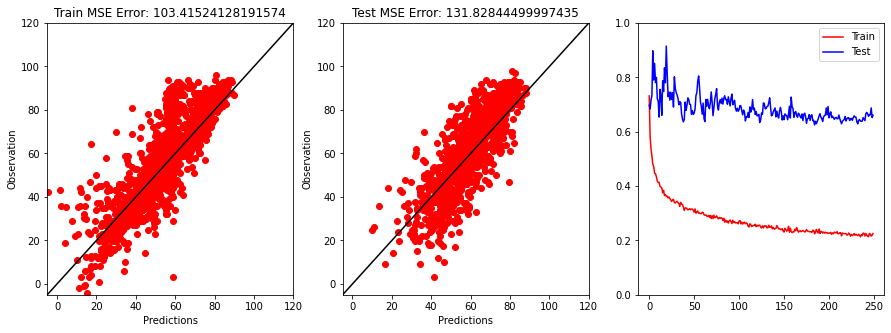

In [ ]:
make3Plots(model, standard_train_features, standard_test_features, history4, standard_model_Y)

# 8. A Few More Parameters to Tune and Layers to Consider

Before we wrap up, lets look at a couple of more parameters that can be changed to help our performance.

**Optimizers/Learning Rate**

Below you will see that we have added an "optimizer" to our compile call. The optimizer determines how the gradient descent is applied. There are several different types of optimizers (Adam, SGD, etc.). In my experiences, Adam seems to be the best general purpose optimizer. What does need to be tuned is the learning rate. Sometimes, the default learning rate is too high. You'll notice this is happening if your model converges after only 1 or 2 epochs. Furthermore, if your model is taking forever to converge, it may be that the learning rate is too low.

<img src="http://hduongtrong.github.io/assets/gradient_descent/all.gif" width="450">

http://hduongtrong.github.io/assets/gradient_descent/all.gif

**Batch Normalization**

Batch normalization is a layer that could probably go in the regularization category above. Remember, that the output from each of the nodes can be looked at as a new feature, so batch normalization in someways can be looked at as attempting to normalize those new features, similar to what we originally did with the data at the start. Note, the placement of the BatchNormalization layer below. We have placed it before the activation. Based on personal experience, you can place the BatchNormalization layer before or after your activiation function, just make sure it is placed before your Dropout layer.

**Model Architecture**

A very common question is what architecture should one be using. How many dense layers? How many nodes in each dense layer?

Ultimately, there is not one correct answer and it is going to take some trial and error to get to an optimal answer. After training a few neural networks, you will start to pick up on what works, and what doesn't. Further guidance can be gained by reading papers where the model architecture is shared. Some general tips though:

1. Start small. A lot of problems can get pretty good results with a single layer.

2. As far the number of nodes go, I always start with a number that is pretty similar to the number of features I have (e.g., in this problem we 252 features, so I might start my first layer with 256 nodes). From there, try reducing the number of nodes. As you add layers, you can keep the number of nodes the same (as I've done below) or try to vary them (e.g., 64 nodes in layer 1, 32 nodes in layer 2, 16 nodes in layer 3, etc.)

3. Generally, more data will allow for more model complexity (i.e., more hidden layers, more nodes, etc.)

4. Always start out with some form of regularization included in your model. I almost always use dropout after my Dense layers. The dropout rate can have a fairly significact impact. I typically test 25%, 50%, and 75% and tune from there.

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 32)                8096      
                                                                 
 batch_normalization_17 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 32)                0         
                                                                 
 dense_84 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_18 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 32)              

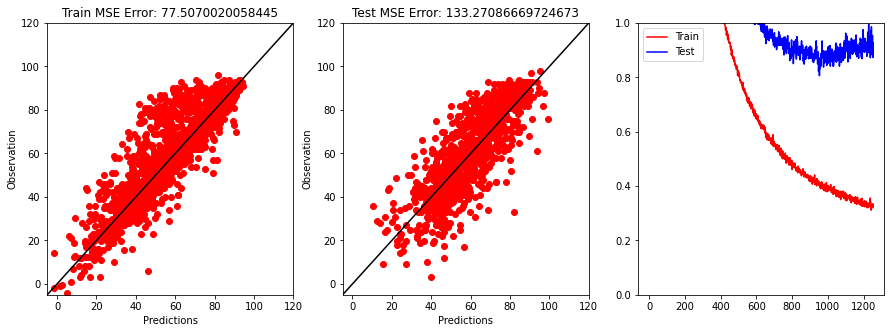

In [ ]:
input_dim = standard_train_features.shape[1] #The input dimension is simply the number of columns (features) in our dataset

model = Sequential()  #Input Layer

#Hidden Layer 1
model.add(Dense(32, kernel_regularizer=regularizer, input_dim=input_dim, kernel_initializer=tf.keras.initializers.HeNormal()))  
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(.2))

#Hidden Layer 2
model.add(Dense(32, kernel_regularizer=regularizer))  
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(.2))

#Hidden Layer 3
model.add(Dense(32, kernel_regularizer=regularizer))  
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(.2))

#Output Layer
model.add(Dense(1))  

opt = tf.keras.optimizers.Adam(learning_rate=0.00005) #.01 to .000001   .001
model.compile(loss='mean_absolute_error', optimizer=opt)

model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
history5 = model.fit(standard_train_features[730:, :], 
                     standard_train_labels[730:, :], 
                     epochs=10000, 
                     batch_size=64, 
                     verbose=0, 
                     callbacks=callback, 
                     validation_data=(standard_train_features[:730, :], standard_train_labels[:730, :]))

make3Plots(model, standard_train_features, standard_test_features, history5, standard_model_Y)

# 8. Binary Prediction

Often we want to make a binary prediction (e.g., yes/no). We can make binary predictions with just a few changes to our our model. But, first lets convert our labels to binary labels. Below, we will predict the probability that a particular day's high temperature will exceed 80F.

Lets start out by looking at the temperature distribution of the training set.

60.08


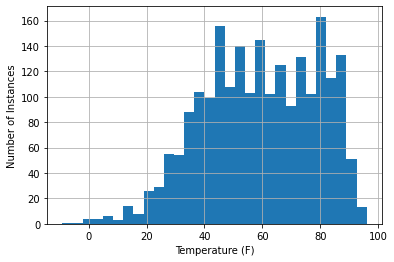

In [ ]:
print(np.percentile(train_labels, 50))
train_labels.hist(bins=30)
plt.xlabel('Temperature (F)')
plt.ylabel("Number of Instances")
plt.show()

Alright, so 60F looks like is close to being the median temperature, lets select that as our threshold.

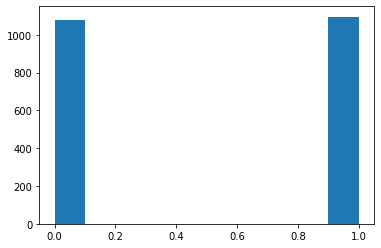

In [ ]:
binary_train_labels = np.zeros(train_labels.shape[0])
binary_train_labels[train_labels > 60] = 1

binary_test_labels = np.zeros(test_labels.shape[0])
binary_test_labels[test_labels > 60] = 1

plt.hist(binary_train_labels)
plt.show()

The data are setup. Now, what do we need to change in our model?

This is the same model we trained above. We are only going to change 2 lines. 

1. The final dense layer, we will change the activation from linear (which was the default setting) to sigmoid (this will bound our predictions to be between 0 and 1.

2. We will change our loss from MSE to binary_crossentropy.

In [ ]:
input_dim = standard_train_features.shape[1] #The input dimension is simply the number of columns (features) in our dataset

model = Sequential()  #Input Layer

#Hidden Layer 1
model.add(Dense(32, kernel_regularizer=regularizer, input_dim=input_dim))  
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(.25))

#Hidden Layer 2
model.add(Dense(32, kernel_regularizer=regularizer, input_dim=input_dim))  
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(.25))

#Output Layer
model.add(Dense(1, activation='sigmoid')) 

opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history6 = model.fit(standard_train_features[730:, :], 
                     binary_train_labels[730:], 
                     epochs=500, 
                     batch_size=64, 
                     verbose=0, 
                     callbacks=callback, 
                     validation_data=(standard_train_features[:730, :], binary_train_labels[:730]))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 32)                8096      
                                                                 
 batch_normalization_20 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 32)                0         
                                                                 
 dropout_41 (Dropout)        (None, 32)                0         
                                                                 
 dense_88 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_21 (Bat  (None, 32)               128       
 chNormalization)                                    

Perfect. Lets take a look at our predictions on the test set.

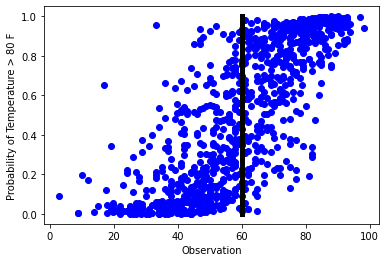

In [ ]:
predictions = model.predict(standard_test_features)
plt.plot(test_labels, predictions, 'bo')
plt.plot([60, 60], [0, 1], 'k', linewidth=5)
plt.xlabel('Observation')
plt.ylabel("Probability of Temperature > 80 F")

plt.show()

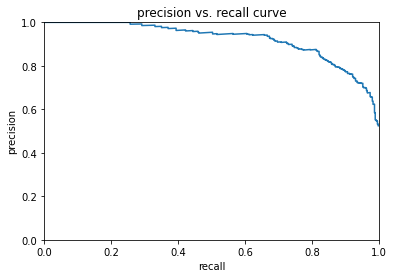

Average Precision Score:  0.922380120337981
50% Threshold Accuracy:  0.8367346938775511


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score

precision, recall, _ = precision_recall_curve(binary_test_labels, predictions)
plt.plot(recall, precision)
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("precision vs. recall curve")
plt.show()

print("Average Precision Score: ", average_precision_score(binary_test_labels, predictions))

predictions_binary = predictions.copy()
predictions_binary[predictions_binary >= .5] = 1
predictions_binary[predictions_binary < .5] = 0
print("50% Threshold Accuracy: ", accuracy_score(binary_test_labels, predictions_binary))

# 9. Exercise

Now it is your turn to pick a new site and/or variable and train your own DL model. Some ideas might include predicting the maximum temperature for a different location or predicting the probability (or the amount) of precipitation for a site.

In [ ]:
#Available sites to choose
print("Sites:")
! ls AI_tutorial_data

Sites:
kbro_processed_data.csv  kdlh_processed_data.csv
kcys_processed_data.csv  kroa_processed_data.csv


In [ ]:
site = 'kdlh'

total_dataset = pd.read_csv('AI_tutorial_data/' + site + '_processed_data.csv',index_col=0).sort_values(by='date')
total_dataset = total_dataset.replace('********', np.nan).replace(np.inf,np.nan).dropna(how='any',axis=1)
total_dataset['date'] = pd.to_datetime(total_dataset['date'])

#pd.options.display.max_columns=2700 #Can uncomment if you want to show every column
total_dataset

,date,OBS_tmpf_max,OBS_tmpf_min,OBS_sknt_max,OBS_phour,GFS0_pmsl_max,GFS0_pmsl_min,GFS0_pmsl_avg,GFS0_pres_max,GFS0_pres_min,GFS0_pres_avg,GFS0_sktc_max,GFS0_sktc_min,GFS0_sktc_avg,GFS0_stc1_max,GFS0_stc1_min,GFS0_stc1_avg,GFS0_snfl_max,GFS0_snfl_min,GFS0_snfl_avg,GFS0_wtns_max,GFS0_wtns_min,GFS0_wtns_avg,GFS0_p01m_max,GFS0_p01m_min,GFS0_p01m_avg,GFS0_c01m_max,GFS0_c01m_min,GFS0_c01m_avg,GFS0_stc2_max,GFS0_stc2_min,GFS0_stc2_avg,GFS0_lcld_max,GFS0_lcld_min,GFS0_lcld_avg,GFS0_mcld_max,GFS0_mcld_min,GFS0_mcld_avg,GFS0_hcld_max,GFS0_hcld_min,...,NAMMOS0_vis_max,NAMMOS0_vis_min,NAMMOS0_vis_avg,NAMMOS0_poz_max,NAMMOS0_poz_min,NAMMOS0_poz_avg,NAMMOS0_pos_max,NAMMOS0_pos_min,NAMMOS0_pos_avg,NAMMOS12_n_x_max,NAMMOS12_tmp_max,NAMMOS12_tmp_min,NAMMOS12_tmp_avg,NAMMOS12_dpt_max,NAMMOS12_dpt_min,NAMMOS12_dpt_avg,NAMMOS12_wdr,NAMMOS12_wsp_max,NAMMOS12_wsp_min,NAMMOS12_wsp_avg,NAMMOS12_p06_max,NAMMOS12_p06_min,NAMMOS12_p06_avg,NAMMOS12_p12_max,NAMMOS12_q06_max,NAMMOS12_q06_min,NAMMOS12_q06_avg,NAMMOS12_q12_max,NAMMOS12_cig_max,NAMMOS12_cig_min,NAMMOS12_cig_avg,NAMMOS12_vis_max,NAMMOS12_vis_min,NAMMOS12_vis_avg,NAMMOS12_poz_max,NAMMOS12_poz_min,NAMMOS12_poz_avg,NAMMOS12_pos_max,NAMMOS12_pos_min,NAMMOS12_pos_avg
3141,2010-12-31,0.00,0.00,0.0,0.00,1007.300000,998.600000,1002.991667,954.300000,944.800000,949.925000,-2.90,-12.000000,-8.025000,268.800000,268.500000,268.633333,17.9,0.0,3.883333,89.000000,89.000000,89.000000,1.600000,0.0,0.466667,0.100000,0.0,0.008333,268.900000,268.500000,268.691667,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,...,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.00,0.0,0.00000,0.0,0.000000,0.00000
0,2011-01-01,26.60,-0.40,23.0,0.05,1010.400000,999.400000,1003.750000,954.700000,943.800000,948.490000,-4.50,-19.600000,-15.210000,272.700000,272.700000,272.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,99.0,62.000000,80.600000,80.000000,0.000000,15.900000,0.000000,0.000000,...,7.0,3.0,4.489583,0.00,0.0,0.00000,100.0,99.333333,99.87500,11.0,4.0,2.0,3.500,-3.0,-5.0,-3.500,250.0,18.0,15.0,16.500,22.0,22.0,22.000000,30.0,0.0,0.0,0.000000,0.0,6.0,6.0,6.000,7.0,5.0,6.00,0.00,0.0,0.00000,100.0,99.333333,99.87500
1,2011-01-02,10.04,-5.08,15.0,0.00,1019.800000,1012.700000,1017.700000,963.500000,957.100000,961.255556,-15.80,-24.900000,-21.361111,272.700000,272.700000,272.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,100.0,12.000000,53.777778,32.000000,0.000000,3.000000,28.000000,0.000000,...,7.0,7.0,7.000000,0.50,0.0,0.06250,100.0,97.250000,99.43750,-8.0,10.0,-8.0,2.250,0.0,-14.0,-6.125,270.0,15.0,5.0,9.625,2.0,0.0,1.333333,3.0,0.0,0.0,0.000000,0.0,8.0,6.0,7.000,7.0,7.0,7.00,0.50,0.0,0.06250,100.0,97.250000,99.43750
2,2011-01-03,10.94,-11.02,8.0,0.00,1020.000000,1012.100000,1017.420833,963.500000,957.400000,961.462500,-10.10,-38.000000,-21.233333,272.700000,272.700000,272.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,99.0,0.000000,63.173913,90.000000,0.000000,50.916667,70.000000,0.000000,...,7.0,7.0,7.000000,0.75,0.0,0.09375,100.0,97.000000,99.34375,-5.0,10.0,-4.0,4.125,2.0,-11.0,-2.875,320.0,8.0,5.0,5.375,10.0,0.0,4.000000,3.0,0.0,0.0,0.000000,0.0,8.0,6.0,7.125,7.0,7.0,7.00,0.75,0.0,0.09375,100.0,97.000000,99.34375
3,2011-01-04,6.98,-7.96,10.0,0.00,1019.500000,1014.400000,1017.095833,962.700000,958.700000,960.575000,-17.70,-25.900000,-21.879167,272.700000,272.700000,272.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,95.0,6.000000,45.291667,70.000000,0.000000,5.750000,1.000000,0.000000,...,7.0,7.0,7.000000,0.75,0.0,0.09375,100.0,97.000000,99.34375,-5.0,8.0,-5.0,2.750,-1.0,

In the next column you can choose which features you want to use (desired_columns). Note, the desired_columns are setup like a wildcard (*) search in a Linux terminal window, so if it contains the phrase you put into the desired_columns list it will be extracted.

In [ ]:
#Subset X data.
desired_columns = ['date', 'lcld', 'mcld', 'hcld', 'pres', 'wsp', 'p06', 'rh', 'tmp']
total_feature_data = total_dataset.loc[:, total_dataset.columns.str.contains('|'.join(desired_columns))]

#Subset Y data.
total_label_data = total_dataset.filter(like='OBS')

In [ ]:
#Pick your variable to predict below.
#predict_variable = 'OBS_tmpf_max'
#predict_variable = 'OBS_tmpf_min'
predict_variable = 'OBS_sknt_max'
#predict_variable = 'OBS_phour'

split_date = datetime(2017, 1, 1)

#Also going to remove data points where the observations were bad (Note this may not be appropriate if you choose a site where temperature values were near 0)
good_obs_rows = (total_label_data['OBS_tmpf_max'] != 0)

#Training data between 2011 and 2016
train_rows = (total_feature_data['date'] < (split_date - timedelta(days=15))) & (good_obs_rows)
train_features = total_feature_data.loc[train_rows, :]
train_features = train_features.drop('date', axis='columns')
train_labels = total_label_data.loc[train_rows, predict_variable]

#Test data 2017 and beyond
test_rows = (total_feature_data['date'] > (split_date + timedelta(days=15))) & (good_obs_rows)
test_features = total_feature_data.loc[test_rows, :]
test_features = test_features.drop('date', axis='columns')
test_labels = total_label_data.loc[test_rows, predict_variable]

#Below can be used if you want to setup a binary problem
threshold = 80
binary_train_labels = np.zeros(train_labels.shape[0])
binary_train_labels[train_labels > threshold] = 1

binary_test_labels = np.zeros(test_labels.shape[0])
binary_test_labels[test_labels > threshold] = 1

Next, scale your data. Feel free to look into other scaling methods, MinMax, RobustScaler, etc.

In [ ]:
from sklearn.preprocessing import StandardScaler

standard_model_X = StandardScaler().fit(train_features)
standard_train_features = standard_model_X.transform(train_features)
standard_test_features = standard_model_X.transform(test_features)

#Note if you choose to do a binary problem. Do not scale your predictand!
standard_model_Y = StandardScaler().fit(train_labels.values.reshape(-1, 1))
standard_train_labels = standard_model_Y.transform(train_labels.values.reshape(-1, 1))
standard_test_labels = standard_model_Y.transform(test_labels.values.reshape(-1, 1))

Now its time to setup the architecture. The first two lines of code are included. The rest you can fill in. Reference back to "The Framework of Our First Deep Learning Model." Feel free to play around with this section after you have a working model. Increase the number of layers, increase the number of nodes, test different values of dropout, etc.

In [ ]:
input_dim = standard_train_features.shape[1] #The input dimension is simply the number of columns (features) in our dataset

model = Sequential()  #Input Layer

In [ ]:
standard_test_labels.mean()

0.13964443187092937

# 10. Solution
Below is a simple solution of what your answer for wind speed prediction could look like.

In [ ]:
input_dim = standard_train_features.shape[1] #The input dimension is simply the number of columns (features) in our dataset

model = Sequential()  #Input Layer

model.add(Dense(32, input_dim=input_dim, activation='relu'))  #Hidden Layer 1
model.add(Dropout(.50))
model.add(Dense(32, activation='relu'))  #Hidden Layer 2
model.add(Dropout(.50))

model.add(Dense(1))  #Output Layer

opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='mean_absolute_error', optimizer=opt)

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 32)                11040     
                                                                 
 dropout_43 (Dropout)        (None, 32)                0         
                                                                 
 dense_91 (Dense)            (None, 32)                1056      
                                                                 
 dropout_44 (Dropout)        (None, 32)                0         
                                                                 
 dense_92 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12,129
Trainable params: 12,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fit your data with a callback. If your model takes all 250 epochs to fit, you might consider turning up the maximum number of epochs.

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
history6 = model.fit(standard_train_features, 
                     standard_train_labels, 
                     epochs=2000, 
                     batch_size=64, 
                     verbose=0, 
                     callbacks=callback, 
                     validation_data=(standard_test_features, standard_test_labels))

In [ ]:
#Remember if you scaled your Y-variable data you have to make sure to "unscale" your data
predictions = model.predict(standard_test_features)
print(predictions)

predictions = standard_model_Y.inverse_transform(predictions) #If working on a binary problem comment this line out
print(predictions)

[[-5.41547596e-01]
 [-7.65465423e-02]
 [-7.15088069e-01]
 [-8.12403023e-01]
 [-6.13301218e-01]
 [-7.62139380e-01]
 [-1.05038238e+00]
 [-1.01971745e+00]
 [-7.11408332e-02]
 [ 3.98662508e-01]
 [ 4.72151309e-01]
 [ 2.12013096e-01]
 [-1.03114344e-01]
 [-8.86843279e-02]
 [-5.45792639e-01]
 [-1.06202938e-01]
 [ 6.38073504e-01]
 [ 8.04594100e-01]
 [ 1.29242182e-01]
 [-3.10663909e-01]
 [-1.79701120e-01]
 [ 3.45158339e-01]
 [ 3.91069055e-01]
 [ 1.25091821e-01]
 [-8.87596533e-02]
 [ 3.80064130e-01]
 [-8.29622746e-01]
 [ 1.15303218e+00]
 [ 2.63212681e-01]
 [ 1.31382740e+00]
 [-2.67202616e-01]
 [-4.24842089e-01]
 [-3.43990326e-01]
 [ 4.62128818e-02]
 [ 2.94558853e-02]
 [ 1.49649471e-01]
 [ 2.41961390e-01]
 [-5.37803471e-01]
 [-4.10264850e-01]
 [ 2.99147934e-01]
 [ 7.90657103e-01]
 [-3.17878500e-02]
 [-6.99969530e-01]
 [-2.51801729e-01]
 [-1.64742619e-01]
 [ 2.94656217e-01]
 [-6.51898623e-01]
 [ 2.24286601e-01]
 [ 1.69747502e-01]
 [ 4.05242771e-01]
 [ 2.58290339e+00]
 [ 2.13677764e+00]
 [ 7.0415198

Text(0, 0.5, 'Observation')

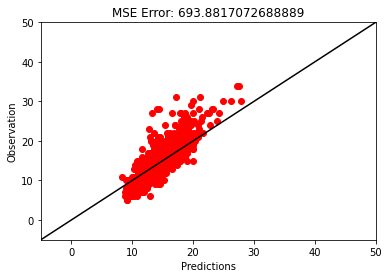

In [ ]:
#If doing binary prediction, it might be best to look at other metrics of skill, such as AUC or CSI
testMSE = mean_squared_error(predictions, test_labels)

title = "MSE Error: " + str(testMSE)
plt.plot(predictions, test_labels, 'ro')
plt.plot(range(-10, 130), range(-10, 130), 'k')
plt.xlim(-5, 50)
plt.ylim(-5, 50)
plt.title(title)
plt.xlabel('Predictions')
plt.ylabel('Observation')

In [ ]:
import itertools

parameters = {'layers': [1, 3],
              'number_nodes': [8, 32],
              'dropout': [.1, .5],
              'loss': ['mean_squared_error', 'mean_absolute_error']}

allNames = parameters
combinations = itertools.product(*(parameters[Name] for Name in allNames))
combinations = list(combinations)

In [ ]:
performance = {}
for key in parameters.keys():
  performance[key] = []
performance['score'] = []

for combination in list(combinations):
  combination_parameters = {}
  for key_idx, key in enumerate(parameters.keys()):
    performance[key].append(combination[key_idx])
    combination_parameters[key] = combination[key_idx]
  print(combination_parameters)

  #Start a new 
  input_dim = standard_train_features.shape[1] 
  model = Sequential()  

  for layer in range(combination_parameters['layers']):
    if layer == 1:
      model.add(Dense(combination_parameters['number_nodes'], input_dim=input_dim, activation='relu'))
    else:
      model.add(Dense(combination_parameters['number_nodes'], activation='relu'))

    model.add(Dropout(combination_parameters['dropout']))

  model.add(Dense(1))  #Output Layer

  opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(loss=combination_parameters['loss'], optimizer=opt)

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
  history6 = model.fit(standard_train_features, 
                      standard_train_labels, 
                      epochs=2000, 
                      batch_size=64, 
                      verbose=0, 
                      callbacks=callback, 
                      validation_data=(standard_test_features, standard_test_labels))
  
  min_validation_loss = np.min(history6.history['val_loss'])
  print(min_validation_loss)
  performance['score'].append(min_validation_loss)

{'layers': 1, 'number_nodes': 8, 'dropout': 0.1, 'loss': 'mean_squared_error'}
29.20651626586914
{'layers': 1, 'number_nodes': 8, 'dropout': 0.1, 'loss': 'mean_absolute_error'}
0.6131051778793335
{'layers': 1, 'number_nodes': 8, 'dropout': 0.5, 'loss': 'mean_squared_error'}
29.364301681518555
{'layers': 1, 'number_nodes': 8, 'dropout': 0.5, 'loss': 'mean_absolute_error'}
0.5881024599075317
{'layers': 1, 'number_nodes': 32, 'dropout': 0.1, 'loss': 'mean_squared_error'}
29.24323081970215
{'layers': 1, 'number_nodes': 32, 'dropout': 0.1, 'loss': 'mean_absolute_error'}
0.5888910293579102
{'layers': 1, 'number_nodes': 32, 'dropout': 0.5, 'loss': 'mean_squared_error'}
29.283369064331055
{'layers': 1, 'number_nodes': 32, 'dropout': 0.5, 'loss': 'mean_absolute_error'}
0.5564592480659485
{'layers': 3, 'number_nodes': 8, 'dropout': 0.1, 'loss': 'mean_squared_error'}
29.343889236450195
{'layers': 3, 'number_nodes': 8, 'dropout': 0.1, 'loss': 'mean_absolute_error'}
0.5971062183380127
{'layers': 3,

In [ ]:
performance = pd.DataFrame(performance)
performance.sort_values(by=['score'])

,layers,number_nodes,dropout,loss,score
7,1,32,0.5,mean_absolute_error,0.556459
13,3,32,0.1,mean_absolute_error,0.576977
3,1,8,0.5,mean_absolute_error,0.588102
5,1,32,0.1,mean_absolute_error,0.588891
9,3,8,0.1,mean_absolute_error,0.597106
1,1,8,0.1,mean_absolute_error,0.613105
15,3,32,0.5,mean_absolute_error,0.620325
11,3,8,0.5,mean_absolute_error,0.735239
0,1,8,0.1,mean_squared_error,29.206516
4,1,32,0.1,mean_squared_error,29.243231
